# <center>UrbanSound8K</center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries-Import" data-toc-modified-id="Libraries-Import-1">Libraries Import</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2">Parameters</a></span></li><li><span><a href="#Import-of-the-Metadata-File" data-toc-modified-id="Import-of-the-Metadata-File-3">Import of the Metadata File</a></span></li><li><span><a href="#Creation-of-the-Dataset-Class" data-toc-modified-id="Creation-of-the-Dataset-Class-4">Creation of the Dataset Class</a></span></li><li><span><a href="#Instantiation-of-the-Dataset" data-toc-modified-id="Instantiation-of-the-Dataset-5">Instantiation of the Dataset</a></span></li><li><span><a href="#Dataset-Exploration" data-toc-modified-id="Dataset-Exploration-6">Dataset Exploration</a></span><ul class="toc-item"><li><span><a href="#Classes-Counts" data-toc-modified-id="Classes-Counts-6.1">Classes Counts</a></span></li><li><span><a href="#Duration-of-Events" data-toc-modified-id="Duration-of-Events-6.2">Duration of Events</a></span></li><li><span><a href="#Salience" data-toc-modified-id="Salience-6.3">Salience</a></span><ul class="toc-item"><li><span><a href="#Global" data-toc-modified-id="Global-6.3.1">Global</a></span></li><li><span><a href="#Per-Class" data-toc-modified-id="Per-Class-6.3.2">Per Class</a></span></li></ul></li><li><span><a href="#Folds-Distribution" data-toc-modified-id="Folds-Distribution-6.4">Folds Distribution</a></span></li><li><span><a href="#Visualition-of-an-Event" data-toc-modified-id="Visualition-of-an-Event-6.5">Visualition of an Event</a></span></li></ul></li><li><span><a href="#Creation-of-the-Model" data-toc-modified-id="Creation-of-the-Model-7">Creation of the Model</a></span></li><li><span><a href="#Creation-of-the-Pipeline" data-toc-modified-id="Creation-of-the-Pipeline-8">Creation of the Pipeline</a></span></li><li><span><a href="#Model-Training-and-Validation" data-toc-modified-id="Model-Training-and-Validation-9">Model Training and Validation</a></span></li></ul></div>

## Libraries Import

In [2]:
import os
import math
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torchmetrics import Accuracy, Precision, Recall, F1, ConfusionMatrix
import torchaudio
import torchaudio.transforms as transforms
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Parameters

In [3]:
########################################################################
dataset_path = "dataset"
########################################################################
# Choose the device to operate on
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Used device: {device}")
########################################################################
# Transforms parameters
target_sample_rate = 22050
target_event_length = 4
n_samples = target_event_length * target_sample_rate
n_fft = 1024
hop_length = 512
f_max = 8000
n_mels = 64
n_frames = (target_sample_rate * target_event_length) // hop_length + 1
transforms_params = {
    "target_sample_rate": target_sample_rate,
    "target_event_length": target_event_length,
    "n_samples": n_samples,
    "n_fft": n_fft,
    "hop_length": hop_length,
    "f_max": f_max,
    "n_mels": n_mels,
    "n_frames": n_frames,
}

Used device: cuda


## Import of the Metadata File

In [4]:
metadata = pd.read_csv("dataset/UrbanSound8K.csv")
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


## Creation of the Dataset Class

In [5]:
class UrbanSound8K(Dataset):
    
    def __init__(self, metadata, dataset_path, transforms_params, device):
        self.device = device
        self.metadata = metadata
        self.dataset_path = dataset_path
        self.n_folds = max(metadata["fold"])
        self.n_classes = len(metadata["class"].unique())
        self.classes_map = classes_map = pd.Series(metadata["class"].values,index=metadata["classID"]).sort_index().to_dict()
        self.target_sample_rate = transforms_params["target_sample_rate"]
        self.target_event_length = transforms_params["target_event_length"]
        self.n_samples = transforms_params["n_samples"]
        self.n_fft = transforms_params["n_fft"]
        self.hop_length = transforms_params["hop_length"]
        self.f_max = transforms_params["f_max"]
        self.n_mels = transforms_params["n_mels"]
        self.n_frames = transforms_params["n_frames"]
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        label = torch.tensor(self._get_event_class(index), dtype=torch.long)
        signal, sr = self._get_event_signal(index)
        signal = signal.to(self.device)
        signal = self._mix_down_if_necessary(signal)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self._spectrogram_transform(signal)
        signal = self._db_transform(signal)
        return signal, label
    
    def _get_event_class(self, index):
        return self.metadata.iloc[index]["classID"]
    
    def _get_event_signal(self, index):
        event_fold = f"fold{self.metadata.iloc[index]['fold']}"
        event_filename = self.metadata.iloc[index]["slice_file_name"]
        audio_path = os.path.join(self.dataset_path, event_fold, event_filename)
        signal, sr = torchaudio.load(audio_path)
        return signal, sr
    
    def _mix_down_if_necessary(self, signal):
        # If signal has multiple channels, mix down to mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resample_transform = resample_transform.to(self.device)
            signal = resample_transform(signal)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.n_samples:
            signal = signal[:, :self.n_samples]
        return signal
        
    def _right_pad_if_necessary(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.n_samples:
            num_missing_samples = self.n_samples - signal_length
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _spectrogram_transform(self, signal):
        mel_spectrogram_transform = transforms.MelSpectrogram(
                                                        sample_rate = self.target_sample_rate,
                                                        n_fft = self.n_fft,
                                                        hop_length = self.hop_length,
                                                        f_max = self.f_max,
                                                        n_mels = self.n_mels,
                                                        power = 2,
                                                        normalized=True
                                                        )      
        mel_spectrogram_transform = mel_spectrogram_transform.to(self.device)
        signal = mel_spectrogram_transform(signal)
        return signal
    
    def _db_transform(self, signal):
        db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")
        db_transform = db_transform.to(self.device)
        signal = db_transform(signal)
        return signal
        

## Instantiation of the Dataset

In [6]:
# Instantiate a dataset object
dataset = UrbanSound8K(
    metadata=metadata,
    dataset_path=dataset_path, 
    transforms_params=transforms_params,
    device=device
)

## Dataset Exploration

### Classes Counts

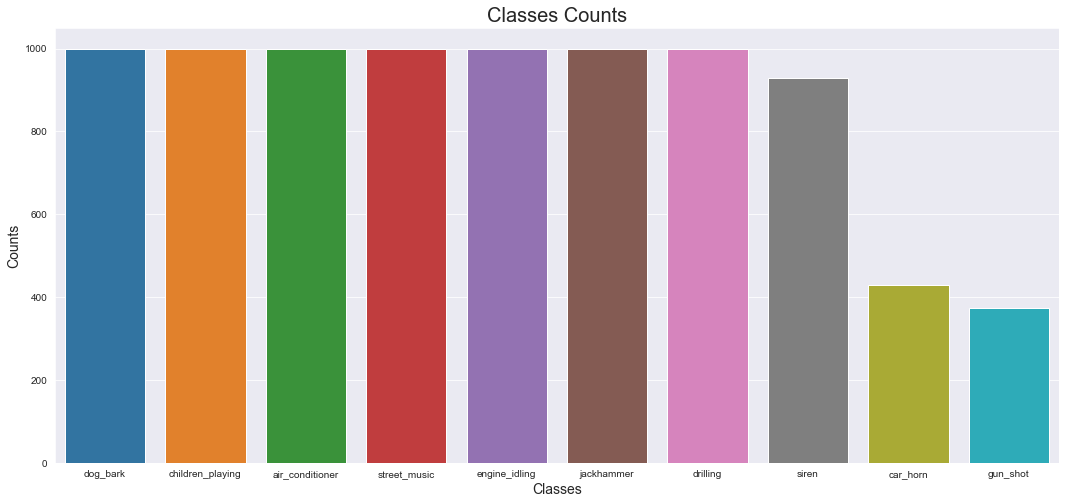

In [7]:
class_vc = dataset.metadata["class"].value_counts()
plt.figure(figsize=(18,8))
sns.barplot(x=class_vc.index, y=class_vc.values)
plt.title("Classes Counts", fontsize=20)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

### Duration of Events

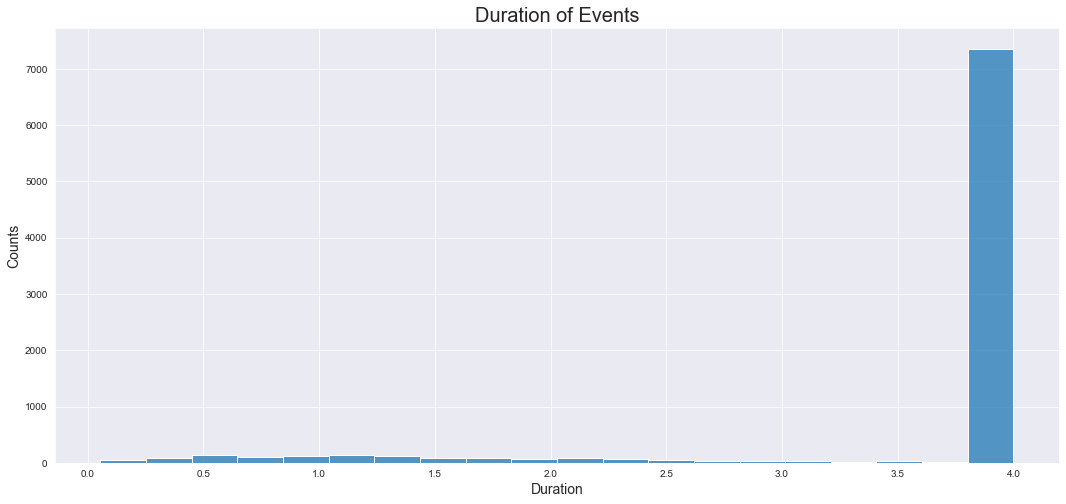

In [9]:
duration = dataset.metadata["end"] - dataset.metadata["start"]
plt.figure(figsize=(18,8))
sns.histplot(data=duration, x=duration.values, bins=20)
plt.title("Duration of Events", fontsize=20)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

### Salience

#### Global

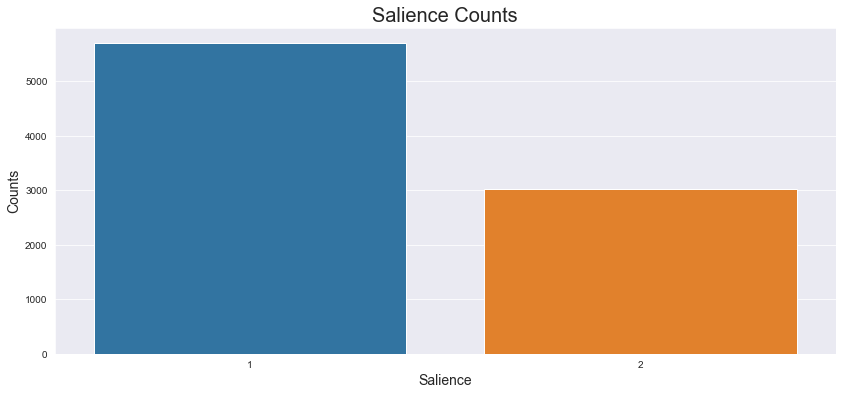

In [10]:
salience_vc = dataset.metadata["salience"].value_counts()
plt.figure(figsize=(14,6))
sns.barplot(x=salience_vc.index, y=salience_vc.values)
plt.title("Salience Counts", fontsize=20)
plt.xlabel("Salience", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

#### Per Class

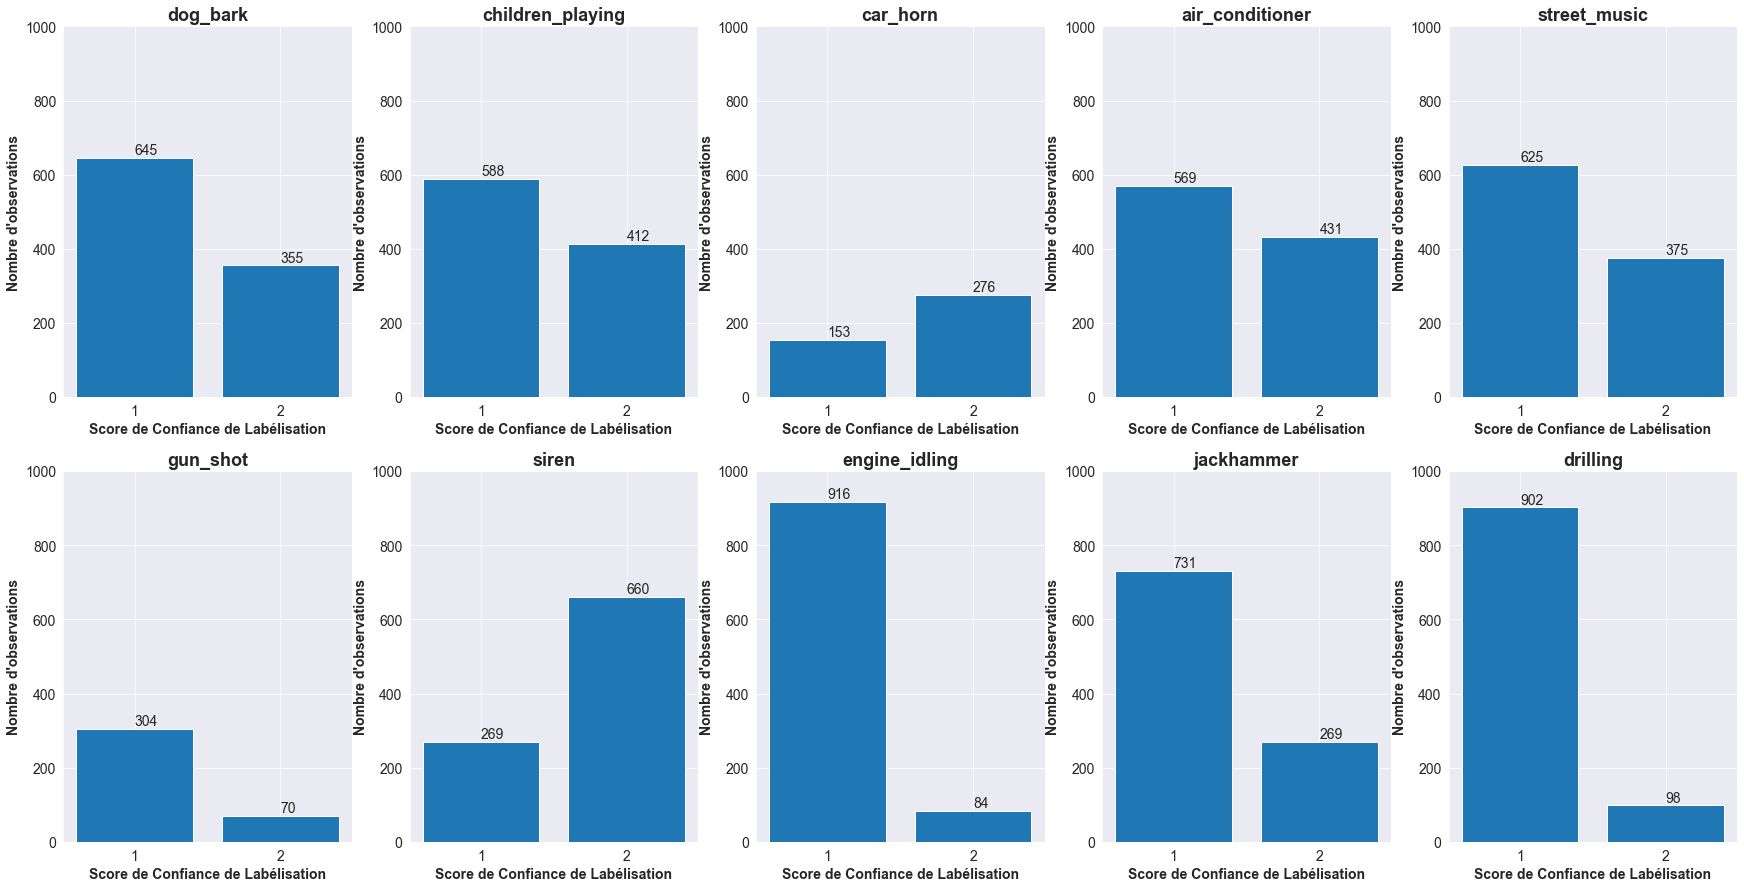

In [11]:
# Set subplot figure parameters
n_cols = 5
n_rows = math.ceil(len(metadata["class"].unique())/n_cols) # Compute the number of rows based on the number of labels and columns
p_count = 1

fig = plt.figure(figsize=(30,15))

# For each unique class
for unique_class in metadata["class"].unique():
    # Filter the metadata based on the label
    filtered_metadata = metadata[metadata["class"]==unique_class]
    # Initialize a dictionnary to count the number events for each salience score
    salience_dict = {1:0, 2:0}
    # For each row of the filtered metadata
    for index, row in filtered_metadata.iterrows():
        # Get the salience score
        salience_score = row[4]
        # Populate the dictionnary
        if salience_score not in salience_dict:
            salience_dict[salience_score] = 1
        else:
            salience_dict[salience_score] += 1
    plt.subplot(n_rows, n_cols, p_count) 
    # Plot a bar graph with all salience scores on the x axis
    plt.bar(range(len(salience_dict)), list(salience_dict.values()), align='center')
    plt.ylim([0, 1000])
    # Write the counts on each bar
    for salience in salience_dict.keys():
        plt.text(salience-1, (filtered_metadata['salience'] == salience).sum()+10, str((filtered_metadata['salience'] == salience).sum()), fontsize=14)
    # Write the ticks on the x axis
    plt.xticks(range(len(salience_dict)), list(salience_dict.keys()), fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"{unique_class}", fontweight="bold", fontsize=18)
    plt.xlabel("Score de Confiance de Labélisation", fontweight="bold", fontsize=14)
    plt.ylabel("Nombre d'observations", fontweight="bold", fontsize=14)
    p_count += 1

plt.show()

### Folds Distribution

In [12]:
# Group by fold and label and pivot
folds_vc = metadata.groupby(["fold", "class"], dropna=False, as_index=False)["class"].size()
folds_vc.pivot(index="class", columns="fold", values="size")

fold,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,
air_conditioner,100,100,100,100,100,100,100,100,100,100
car_horn,36,42,43,59,98,28,28,30,32,33
children_playing,100,100,100,100,100,100,100,100,100,100
dog_bark,100,100,100,100,100,100,100,100,100,100
drilling,100,100,100,100,100,100,100,100,100,100
engine_idling,96,100,107,107,107,107,106,88,89,93
gun_shot,35,35,36,38,40,46,51,30,31,32
jackhammer,120,120,120,120,120,68,76,78,82,96
siren,86,91,119,166,71,74,77,80,82,83


### Visualition of an Event

,slice_file_name,fsID,start,end,salience,fold,classID,class
3619,174294-6-0-0.wav,174294,0.0,2.535721,1,1,6,gun_shot


tensor([[ -45.5880,  -26.5687,  -32.3262,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -49.2232,  -22.7966,  -41.3743,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -51.0430,  -19.0745,  -37.5543,  ..., -100.0000, -100.0000,
         -100.0000],
        ...,
        [ -42.4310,  -15.8947,  -25.0185,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -42.2691,  -16.8464,  -28.0544,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -42.3982,  -17.4802,  -26.9800,  ..., -100.0000, -100.0000,
         -100.0000]])
tensor(-3.9387)
tensor(-100.)


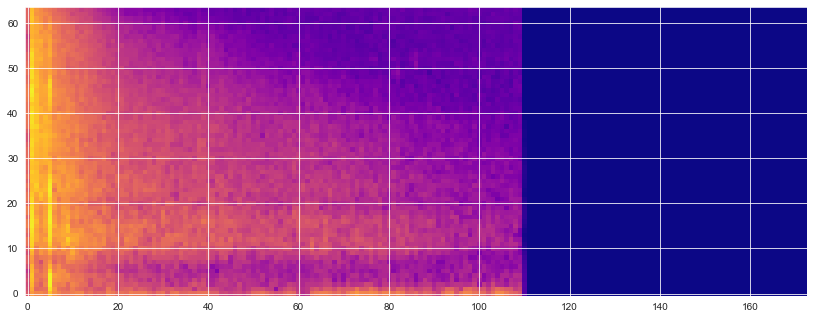

In [13]:
# Input annotations filtering critera
label = "gun_shot"
salience = 1 

# Filter annotations based on criteria
filtered_metadata = dataset.metadata.loc[
    (metadata["class"]==label)
    & (metadata["salience"]==salience)
    ]

# Randomly select the desired number of events from the filtered annotations
selected_event = filtered_metadata.sample(n=1) 
display(selected_event)
selected_event_index = selected_event.index.item()

spectrogram, label = dataset[selected_event_index]

spectrogram = spectrogram.cpu()
spectrogram = torch.squeeze(spectrogram)

print(spectrogram)
print(spectrogram.max())
print(spectrogram.min())

plt.figure(figsize=(14,14))
plt.imshow(spectrogram, origin="lower", cmap='plasma')

# Build the audio path
selected_event_fold = f"fold{selected_event.iloc[0]['fold']}"
selected_event_filename = selected_event.iloc[0]["slice_file_name"]
selected_audio_path = os.path.join(dataset_path, selected_event_fold, selected_event_filename)
display(IPython.display.Audio(filename=selected_audio_path))

## Creation of the Model

In [14]:
class Model(nn.Module):
    
    def __init__(self, out_dim):
        
        super().__init__()
        # Definition of the model
        self.conv1 = nn.Sequential(
                                nn.Conv2d(
                                            in_channels=1,
                                            out_channels=16,
                                            kernel_size=3,
                                            stride=1,
                                            padding=2
                                            ),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2)
                                )
        self.conv2 = nn.Sequential(
                                nn.Conv2d(
                                            in_channels=16,
                                            out_channels=32,
                                            kernel_size=3,
                                            stride=1,
                                            padding=2
                                            ),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2)
                                )
        self.conv3 = nn.Sequential(
                                nn.Conv2d(
                                            in_channels=32,
                                            out_channels=64,
                                            kernel_size=3,
                                            stride=1,
                                            padding=2
                                            ),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2)
                                )
        self.conv4 = nn.Sequential(
                                nn.Conv2d(
                                            in_channels=64,
                                            out_channels=128,
                                            kernel_size=3,
                                            stride=1,
                                            padding=2
                                            ),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2)
                                )  
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 12, out_dim)
    
    def forward(self, input_data):
        
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        
        return logits

## Creation of the Pipeline

In [15]:
class Pipeline(pl.LightningModule):
    def __init__(self, model, classes_map, lr):
        super().__init__()
        
        # Save hyperparameters to the checkpoint
        self.save_hyperparameters()        

        # Instantiate the model
        self.model = model
           
        # Instiation of the metrics
        self.accuracy = Accuracy(num_classes=len(classes_map), average="weighted")
        self.recall = Recall(num_classes=len(classes_map), average="weighted")
        self.f1_score = F1(num_classes=len(classes_map), average="weighted")
        self.confmat = ConfusionMatrix(num_classes=len(classes_map))           
        
        # Instantiation of the classes map
        self.classes_map = classes_map
        
        # Instantiation of the number of classes
        self.n_classes = len(classes_map)
        
        # Instatiation of the learning rate
        self.lr = lr
        
        
    def configure_optimizers(self):
        
        optimizer = Adam(self.model.parameters(), lr=self.lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
            
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                        "scheduler": scheduler,
                        "monitor": "validation_loss",
                        "frequency": 1
                        }
                }
        
    def training_step(self, train_batch, batch_idx): 
        
        # Unpack the training batch
        inputs, targets = train_batch
        # Pass the inputs to the model to get the logits
        logits = self.model(inputs)
        # Compute the loss
        loss = F.cross_entropy(logits, targets)
        # Get the probabilities for each class by applying softmax
        probs = F.softmax(logits, dim=1)
        # Get the prediction for each batch sample
        _, preds = torch.max(probs, 1)
        # Compute the accuracy
        accuracy = self.accuracy(logits, targets)
        # Log the loss
        self.log("training_loss", loss, on_step=True, on_epoch=True)
        
        return {"inputs":inputs, "targets":targets, "predictions":preds, "loss":loss}
    
    
    def training_epoch_end(self, outputs):
        
        if self.current_epoch == 0:
            input_height = outputs[0]["inputs"].size()[2]
            input_width = outputs[0]["inputs"].size()[3]
            input_sample = torch.rand((1,1,input_height,input_width)).to(self.device)
            self.logger.experiment.add_graph(self.model, input_sample)

            
    def validation_step(self, validation_batch, batch_idx):
        
        # Unpack the validation batch
        inputs, targets = validation_batch
        # Pass the inputs to the model to get the logits
        logits = self.model(inputs)
        # Compute the loss and log it for early stopping monitoring
        loss = F.cross_entropy(logits, targets)
        # Get the probabilities for each class by applying softmax
        probs = F.softmax(logits, dim=1)
        # Get the prediction for each batch sample
        _, preds = torch.max(probs, 1)
        # Compute the accuracy for this batch
        accuracy = self.accuracy(preds, targets)
        # Log the loss and the accuracy
        self.log("validation_loss", loss, on_step=True, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_step=True, on_epoch=True)
        
        return {"inputs":inputs, "targets":targets, "predictions":preds, "loss":loss}
    
    
    def validation_epoch_end(self, outputs):
        
        # Concatenate the predictions of all batches
        preds = torch.cat([output["predictions"] for output in outputs])
        # Concatenate the targets of all batches
        targets = torch.cat([output["targets"] for output in outputs])
        # Compute the confusion matrix, turn it into a DataFrame, generate the plot and log it
        cm = self.confmat(preds, targets)
        cm = cm.cpu()
        
        for class_id in range(self.n_classes):
                precision = cm[class_id, class_id] / torch.sum(cm[:,class_id])
                precision = round(precision.item()*100,1)
                self.log(f"validation_precision/{class_id}",precision)
                recall = cm[class_id, class_id] / torch.sum(cm[class_id,:])
                recall = round(recall.item()*100,1)
                self.log(f"validation_recall/{class_id}",recall)
      
        df_cm = pd.DataFrame(cm.numpy(), index = range(self.n_classes), columns=range(self.n_classes))
        plt.figure()
        fig = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.yticks(rotation=0)
        self.logger.experiment.add_figure("Confusion matrix", fig, self.current_epoch)
        
    def on_save_checkpoint(self, checkpoint):
        # Get the state_dict from self.model to get rid of the "model." prefix
        checkpoint["state_dict"] = self.model.state_dict()

## Model Training and Validation

In [16]:
# Batch size
batch_size = 32
# Number of epochs
n_epochs = 30
# Learning rate
learning_rate = 2e-4

for i in range(1,dataset.n_folds+1):
    
    print(f"========== Cross-validation {i} on {dataset.n_folds} ==========")
    
    # Get the train and validation sets
    train_metadata = dataset.metadata.drop(dataset.metadata[dataset.metadata["fold"]==i].index)
    validation_metadata = dataset.metadata[dataset.metadata["fold"]==i]
    train_indices = train_metadata.index
    validation_indices = validation_metadata.index 
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    # Create the train and validation dataloaders
    train_dataloader = DataLoader(
                            dataset, 
                            batch_size=batch_size, 
                            sampler=train_sampler,
                            )
    
    validation_dataloader = DataLoader(
                            dataset, 
                            batch_size=batch_size,
                            sampler=validation_sampler,
                            )

    # Instantiate the model
    model = Model(out_dim=dataset.n_classes)
    
    # Instantiate the pipeline
    pipeline = Pipeline(model, classes_map=dataset.classes_map, lr=learning_rate)
    
    # Instantiate the logger
    run_name = f"{dataset.n_folds} folds cross-validation - Validation on fold {i}"
    tensorboard_logger = TensorBoardLogger(save_dir="logs", name=run_name)
    
    # Instantiate a learning rate monitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    # Instantiate early stopping based on epoch validation loss
    early_stopping = EarlyStopping("validation_loss", patience=6, verbose=True)
    
    # Instantiate a checkpoint callback
    checkpoint = ModelCheckpoint(
                            dirpath=f"./checkpoints/{dataset.n_folds} folds cross-validation - Validation on fold {i}",
                            filename="{epoch}-{validation_loss:.2f}",
                            verbose=True,
                            monitor="validation_loss",
                            save_last = False,
                            save_top_k=1,      
                            mode="min",
                            save_weights_only=True
                            )
    
    # Instantiate the trainer and train the model
    trainer = Trainer(
                    gpus=-1,
                    max_epochs=n_epochs, 
                    logger=tensorboard_logger,
                    log_every_n_steps = 1,
                    callbacks=[early_stopping, lr_monitor, checkpoint]
                    )   
    
    trainer.fit(pipeline, train_dataloader, validation_dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 1 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:458: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.490
Epoch 0, global step 245: validation_loss reached 1.48994 (best 1.48994), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 1\epoch=0-validation_loss=1.49.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 491: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 737: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 983: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1229: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1475: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.490. Signaling Trainer to stop.
Epoch 6, global step 1721: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 2 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.350
Epoch 0, global step 245: validation_loss reached 1.34982 (best 1.34982), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=0-validation_loss=1.35.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.314
Epoch 1, global step 491: validation_loss reached 1.31392 (best 1.31392), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=1-validation_loss=1.31.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.281
Epoch 2, global step 737: validation_loss reached 1.28106 (best 1.28106), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=2-validation_loss=1.28.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.154
Epoch 3, global step 983: validation_loss reached 1.15417 (best 1.15417), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=3-validation_loss=1.15.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1229: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1475: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1721: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1967: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2213: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.154. Signaling Trainer to stop.
Epoch 9, global step 2459: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 3 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.351
Epoch 0, global step 243: validation_loss reached 1.35117 (best 1.35117), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 3\epoch=0-validation_loss=1.35.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 487: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 731: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 975: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1219: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1463: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.351. Signaling Trainer to stop.
Epoch 6, global step 1707: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 4 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.404
Epoch 0, global step 241: validation_loss reached 1.40430 (best 1.40430), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 4\epoch=0-validation_loss=1.40.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.180 >= min_delta = 0.0. New best score: 1.225
Epoch 1, global step 483: validation_loss reached 1.22454 (best 1.22454), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 4\epoch=1-validation_loss=1.22.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 725: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 967: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.199
Epoch 4, global step 1209: validation_loss reached 1.19918 (best 1.19918), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 4\epoch=4-validation_loss=1.20.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1451: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.158
Epoch 6, global step 1693: validation_loss reached 1.15813 (best 1.15813), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 4\epoch=6-validation_loss=1.16.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1935: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2177: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 2419: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 2661: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 2903: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.158. Signaling Trainer to stop.
Epoch 12, global step 3145: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 5 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.311
Epoch 0, global step 243: validation_loss reached 1.31079 (best 1.31079), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 5\epoch=0-validation_loss=1.31.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.223 >= min_delta = 0.0. New best score: 1.087
Epoch 1, global step 487: validation_loss reached 1.08742 (best 1.08742), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 5\epoch=1-validation_loss=1.09.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.153 >= min_delta = 0.0. New best score: 0.935
Epoch 2, global step 731: validation_loss reached 0.93475 (best 0.93475), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 5\epoch=2-validation_loss=0.93.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.077 >= min_delta = 0.0. New best score: 0.858
Epoch 3, global step 975: validation_loss reached 0.85803 (best 0.85803), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 5\epoch=3-validation_loss=0.86.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1219: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.813
Epoch 5, global step 1463: validation_loss reached 0.81342 (best 0.81342), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 5\epoch=5-validation_loss=0.81.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.793
Epoch 6, global step 1707: validation_loss reached 0.79281 (best 0.79281), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 5\epoch=6-validation_loss=0.79.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1951: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2195: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 2439: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 2683: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 2927: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 0.793. Signaling Trainer to stop.
Epoch 12, global step 3171: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 6 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.356
Epoch 0, global step 247: validation_loss reached 1.35637 (best 1.35637), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 6\epoch=0-validation_loss=1.36.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.323
Epoch 1, global step 495: validation_loss reached 1.32313 (best 1.32313), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 6\epoch=1-validation_loss=1.32.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.163 >= min_delta = 0.0. New best score: 1.160
Epoch 2, global step 743: validation_loss reached 1.16031 (best 1.16031), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 6\epoch=2-validation_loss=1.16.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 991: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1239: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1487: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1735: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1983: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.160. Signaling Trainer to stop.
Epoch 8, global step 2231: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 7 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.287
Epoch 0, global step 246: validation_loss reached 1.28722 (best 1.28722), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=0-validation_loss=1.29.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.180 >= min_delta = 0.0. New best score: 1.107
Epoch 1, global step 493: validation_loss reached 1.10741 (best 1.10741), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=1-validation_loss=1.11.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.113 >= min_delta = 0.0. New best score: 0.994
Epoch 2, global step 740: validation_loss reached 0.99437 (best 0.99437), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=2-validation_loss=0.99.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 987: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1234: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1481: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1728: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.941
Epoch 7, global step 1975: validation_loss reached 0.94078 (best 0.94078), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=7-validation_loss=0.94.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.922
Epoch 8, global step 2222: validation_loss reached 0.92230 (best 0.92230), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=8-validation_loss=0.92.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 2469: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 2716: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 2963: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 3210: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 3457: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 0.922. Signaling Trainer to stop.
Epoch 14, global step 3704: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 8 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.281
Epoch 0, global step 247: validation_loss reached 1.28132 (best 1.28132), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 8\epoch=0-validation_loss=1.28.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.234 >= min_delta = 0.0. New best score: 1.047
Epoch 1, global step 495: validation_loss reached 1.04729 (best 1.04729), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 8\epoch=1-validation_loss=1.05.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 743: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 991: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1239: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1487: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1735: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.047. Signaling Trainer to stop.
Epoch 7, global step 1983: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 9 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.164
Epoch 0, global step 247: validation_loss reached 1.16406 (best 1.16406), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 9\epoch=0-validation_loss=1.16.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.123 >= min_delta = 0.0. New best score: 1.041
Epoch 1, global step 495: validation_loss reached 1.04139 (best 1.04139), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 9\epoch=1-validation_loss=1.04.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 743: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.022
Epoch 3, global step 991: validation_loss reached 1.02198 (best 1.02198), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 9\epoch=3-validation_loss=1.02.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1239: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1487: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1735: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1983: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2231: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.022. Signaling Trainer to stop.
Epoch 9, global step 2479: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 10 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.229
Epoch 0, global step 246: validation_loss reached 1.22860 (best 1.22860), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 10\epoch=0-validation_loss=1.23.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.159
Epoch 1, global step 493: validation_loss reached 1.15934 (best 1.15934), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 10\epoch=1-validation_loss=1.16.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.122 >= min_delta = 0.0. New best score: 1.037
Epoch 2, global step 740: validation_loss reached 1.03698 (best 1.03698), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 10\epoch=2-validation_loss=1.04.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 987: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1234: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1481: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.037
Epoch 6, global step 1728: validation_loss reached 1.03661 (best 1.03661), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 10\epoch=6-validation_loss=1.04.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1975: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2222: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 2469: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 2716: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 2963: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.037. Signaling Trainer to stop.
Epoch 12, global step 3210: validation_loss was not in top 1
